# FrostAura Plutus
### Mark 10
This iteration of the decision engine will consist of neural network-based architecture. A Deep Q-learning agent.

## Features
The environment's observable space will consist of features the shape of multiple dimensions as follows.
- Prices of the pair with time.
- A few indicators at various configurations for the closing price.
- Whether we currently have an open stake in this pair or not. 

In [1]:
# Load features from pickle generated by the ./parse_market_data notebook.
import pickle

model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

In [2]:
# Configure the pair we will work with for testing.
pair_df = featurized_market_data['AAVE_BTC']

Text(0, 0.5, 'Close Price')

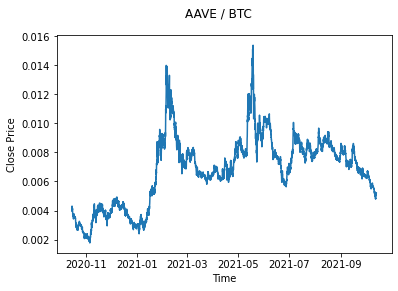

In [3]:
# Visualize close prices.
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()

plt.plot(pair_df['time'], pair_df['close'])
fig.suptitle('AAVE / BTC')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [4]:
# Add non-indicator observation values.
pair_df['staked'] = False
pair_df['base_balance'] = 0

### Dimension 1
The 1st dimension's features consist of 38 items. This dimension is meant to represent all values observable in a flat array per-timestep. 
- The usual open, close, lower, upper and volume.
- The deconstructed time (for seasonality).
- The moving average of the closing price.
- ADX momentum indicator on the close price.
- The RSI on the close price with a period of 14.
- Stoch slow on the close price with a period of 14.
- Bolinger Bands with std 2 on the close price with a period of 14.
- Bolinger Bands with std 3 on the close price with a period of 14.
- Bolinger Bands with std 4 on the close price with a period of 14.
- The RSI on the close price with a period of 20.
- Stoch slow on the close price with a period of 20.
- Bolinger Bands with std 2 on the close price with a period of 20.
- Bolinger Bands with std 3 on the close price with a period of 20.
- Bolinger Bands with std 4 on the close price with a period of 20.
- Whether we have a current stake in this pair. (This means support for one transaction p/pair at a time)
- How much base currency is available to spend on purchasing.

In [5]:
pair_df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'hour', 'day', 'week',
       'month', 'sma', 'rsi_tp14', 'adx', 'stoch_slow_k_tp_14',
       'stoch_slow_d_tp_14', 'bb_upper_tp14_sd2', 'bb_middle_tp14_sd2',
       'bb_lower_tp14_sd2', 'bb_upper_tp14_sd3', 'bb_middle_tp14_sd3',
       'bb_lower_tp14_sd3', 'bb_upper_tp14_sd4', 'bb_middle_tp14_sd4',
       'bb_lower_tp14_sd4', 'rsi_tp20', 'stoch_slow_k_tp_20',
       'stoch_slow_d_tp_20', 'bb_upper_tp20_sd2', 'bb_middle_tp20_sd2',
       'bb_lower_tp20_sd2', 'bb_upper_tp20_sd3', 'bb_middle_tp20_sd3',
       'bb_lower_tp20_sd3', 'bb_upper_tp20_sd4', 'bb_middle_tp20_sd4',
       'bb_lower_tp20_sd4', 'staked', 'base_balance'],
      dtype='object')

### Dimension 2
The 2nd dimension's features represent timesteps for dimension 1.
- Window length of historical record counts to make observable.
#### Example
In the example below we choose to have a window of 4 historical adjacent to an inclusive current record.
At this point, dimension 1 (38) + dimension 2 (5) = ***double[5][38]***
| | | | | |
|---|---|---|---|---|
| 0 | 1 | 2 | .. | 38 |
| 1 | - | - | - | - |
| 2 | - | - | - | - |
| .. | - | - | - | - |
| 5 | - | - | - | - |

In [6]:
# Visualize the last X records.
pair_df.tail(5)

,time,open,high,low,close,volume,hour,day,week,month,...,bb_middle_tp20_sd2,bb_lower_tp20_sd2,bb_upper_tp20_sd3,bb_middle_tp20_sd3,bb_lower_tp20_sd3,bb_upper_tp20_sd4,bb_middle_tp20_sd4,bb_lower_tp20_sd4,staked,base_balance
8694,2021-10-13 03:00:00,0.005103,0.005106,0.005082,0.005099,291.906,3,13,41,10,...,0.005004,0.004792,0.005322,0.005004,0.004686,0.005428,0.005004,0.004580,False,0
8695,2021-10-13 04:00:00,0.005099,0.005373,0.005090,0.005177,5636.194,4,13,41,10,...,0.005018,0.004801,0.005345,0.005018,0.004692,0.005453,0.005018,0.004583,False,0
8696,2021-10-13 05:00:00,0.005177,0.005261,0.005119,0.005203,2228.796,5,13,41,10,...,0.005037,0.004823,0.005357,0.005037,0.004717,0.005464,0.005037,0.004610,False,0
8697,2021-10-13 06:00:00,0.005201,0.005216,0.005164,0.005176,736.389,6,13,41,10,...,0.005054,0.004854,0.005354,0.005054,0.004754,0.005455,0.005054,0.004654,False,0
8698,2021-10-13 07:00:00,0.005175,0.005219,0.005173,0.005191,623.010,7,13,41,10,...,0.005071,0.005071,0.005071,0.005071,0.005071,0.005071,0.005071,0.005071,False,0


## Create a Trading Reinforcement Learning Gym Environment
In this particular case we will go with [OpenAI's gym](https://gym.openai.com/docs/) interface. 

### Action Space
0) Buy
1) Sell
2) Hold

### Observation Space
- All of the features from the above dataframe, limited to the <window_length> most recent records, inclusive of the most recent one.

In [7]:
import numpy as np
import gym
from gym import spaces
from enum import IntEnum

In [8]:
class ActionType(IntEnum):
    Buy = 0
    Sell = 1
    Hold = 2

In [9]:
class PairTradingEnvironment(gym.Env):
    """A custom reinforcement learning environment for trading pairs."""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, prices_dataframe, comission_percentage=0.03, window_size=48):
        super(PairTradingEnvironment, self).__init__()
        
        # TODO: Strip out time from the observation space. The agent doesn't need that. We do when traversing over the data.
        feature_count = len(prices_dataframe.columns)
        historical_record_count = window_size

        self.done = False
        self.comission_percentage = comission_percentage
        self.prices_dataframe = prices_dataframe
        self.action_space = spaces.Discrete(len(ActionType))
        
        # TODO: Define observation space with correct window for data. Keep index of window. Perhaps use deque in Python.
        # Perhaps add into one stack (window_size) while dequing from another collection (prices_dataframe).
        self.observation_space = spaces.Box(low=0, high=1, shape=(historical_record_count, feature_count), dtype=np.float16)

    def _next_observation(self):
        observation = []
        
        return observation

    def step(self, action):
        observation = self._next_observation()
        reward = 0
        info = {}
        
        return observation, reward, self.done, info
    def reset(self):
        initial_observation = self._next_observation()
        
        return initial_observation

In [10]:
env = PairTradingEnvironment(pair_df)
obs = env.reset()

obs

[]

# Next
### Mark 11
Add another dimension to the observable space to have all pairs available as to allow the agent to learn causal relationships between pairs. For example if ETH dips, BTC has a certain probability to respond to that in a certain way.